# Anomaly Detection using Sensor Data

## Objective
The goal of this task is to identify anomalies using sensor data.
Since anomaly cases are very rare compared to normal cases, accuracy alone
is not reliable. Therefore, the main focus is on recall and F1-score for
detecting anomalies.


##Modules Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

##Reading Datasets

In [3]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1639424, 7)
Test shape: (409856, 7)


In [5]:
train.head()
train['target'].value_counts()

,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


## Data Preprocessing
The date column is broken down into year, month, day, and day of the week.
This helps the model understand time-based patterns in the data.


In [6]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

for df in [train, test]:
  df['year'] = df['Date'].dt.year
  df['month'] = df['Date'].dt.month
  df['day'] = df['Date'].dt.day
  df['dayofweek'] = df['Date'].dt.dayofweek

train.drop(columns=['Date'], inplace=True)
test.drop(columns=['Date'], inplace=True)

In [7]:
# Convert target to int
train['target'] = train['target'].astype(int)

# Separate features and target
X = train.drop(columns=['target'])
y = train['target']

X_test = test.drop(columns=['ID'])

In [8]:
# Fill missing values
X = X.fillna(X.median())
X_test = X_test.fillna(X.median())

##Data Visualization

The dataset is highly imbalanced, with anomalies forming a very small
percentage of total observations.

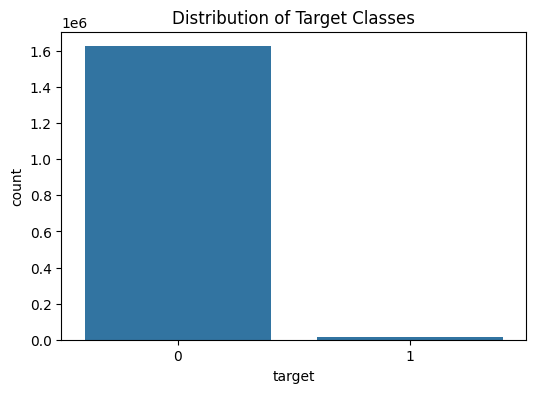

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train)
plt.title('Distribution of Target Classes')
plt.show()

## Train/Test Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 1. Baseline Model – Logistic Regression
Logistic Regression was used as a basic baseline model.
Due to the highly imbalanced dataset, it performed poorly in detecting anomalies
and was not able to capture complex patterns in the data.

In [11]:
lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=2000)

In [12]:
y_pred_lr = lr.predict(X_val)
print("Logistic Regression Performance:\n")
print(classification_report(y_val, y_pred_lr))
print("F1 Score:", f1_score(y_val, y_pred_lr))

Logistic Regression Performance:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    325077
           1       0.00      0.00      0.00      2808

    accuracy                           0.99    327885
   macro avg       0.50      0.50      0.50    327885
weighted avg       0.98      0.99      0.99    327885

F1 Score: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 2. Main Model – Random Forest Classifier
Random Forest was selected as the main model because it can handle
more complex patterns and class imbalance.
It achieved high recall and a reasonable F1-score for the anomaly class.

In [13]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=50, n_jobs=-1, random_state=42)

In [14]:
y_pred = rf.predict(X_val)
print("Random Forest Performance:\n")
print(classification_report(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

Random Forest Performance:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    325077
           1       0.24      0.93      0.38      2808

    accuracy                           0.97    327885
   macro avg       0.62      0.95      0.69    327885
weighted avg       0.99      0.97      0.98    327885

F1 Score: 0.3845701689933872
